In [1]:
import qiskit as qk
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli
from scipy.signal import convolve2d
from qiskit.circuit import Parameter
from sympy import *
from qiskit import IBMQ
import tkinter
import math
import os
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
def place_piece(turn, board, row, col):
    if turn % 2 == 0: board[row-1][col-1] = 'X'
    else: board[row-1][col-1] = 'O'
            
def idx(row, col, n): return n*row+col

def get_min_num_qubits(n):
    search_size = n**2
    num = 0
    while True:
        if search_size <= 2**num: return num
        num += 1
    
def is_power_of_2(n):
    return math.ceil(math.log10(n)/math.log10(2)) == math.floor(math.log10(n)/math.log10(2))

In [3]:
def end_state(board, num_connect, turn):
    board_cpy = [row[:] for row in board]
    for row in range(n):
        for col in range(n):
            if board_cpy[row][col] == 'X': board_cpy[row][col] = 1 if turn % 2 == 0 else 0
            if board_cpy[row][col] == 'O': board_cpy[row][col] = 1 if turn % 2 == 1 else 0
    horizontal_kernel = np.array([[1]*num_connect])
    vertical_kernel = np.transpose(horizontal_kernel)
    diag1_kernel = np.eye(num_connect)
    diag2_kernel = np.fliplr(diag1_kernel)
    detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]
    for kernel in detection_kernels:
        if (convolve2d(board_cpy, kernel, mode="valid") == num_connect).any():
            return True
    return False

def get_int_from_user(message="", lower_bound=1):
    loop_bool = True
    while loop_bool:
        try:
            ret = int(input(message))
            if lower_bound <= ret: loop_bool = False
            else: print("Invalid input: lower bound = {}".format(lower_bound))
        except ValueError: print("Could not read user input")
    return ret

a, b, c, d, e, g, h, i, j,k,l ,m,n,o,p,q,r,s,t,u,v,w,x,y,z= symbols('a b c d e g h i j k m l n o p q r s t u v w x y z')
alphabet= [a,b,c,d,e,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z]
init_printing(use_unicode=True)

In [4]:
def has_token(position, qc_positions, opp_positions):
    for it in qc_positions:
        if (position[0]==it[0]):
            if(position[1]==it[1]):
                return 1
    for it in opp_positions:
        if (position[0]==it[0]):
            if(position[1]==it[1]):
                return -1
    return 0

def change_of_base(position,n):
    qpos=[]
    rows=position[0]
    cols=position[1]
    for it in range(round(math.log(n,2))):
        #Rows
        if(rows>=(n/(2**(it+1)))):
            qpos.append(1)
            rows=rows-(n/(2**(it+1)))
        else:
            qpos.append(0)
        #columns
        if(cols>=(n/(2**(it+1)))):
            qpos.append(1)
            cols=cols-(n/(2**(it+1)))
        else:
            qpos.append(0)
    return qpos

In [5]:
def rev_change_of_base(bitstr, n):
    print(bitstr)
    col=0
    row=0
    counter=0
    pos_counter=2
    for it in bitstr:
        if(pos_counter%2==0):
            if (int(it)==1):
                col+= (2**(counter))
            pos_counter+=1
        else:
            if (int(it)==1):
                row+= (2**(counter))
            counter+=1
            pos_counter+=1
    return (row,col)

def writer(position,n):
    qpos = change_of_base(position,n)
    temp_func = 1
    counter = 0
    for sub_qpos in qpos:
            if sub_qpos==1: temp_func *= (1-alphabet[counter])/2
            else: temp_func *= (1-((1-alphabet[counter])/2))
            counter+=1
    return temp_func

In [19]:
def Int_cost(position,qc_positions, opp_positions,all_costs,n):
    inter_cost = 0
    #left edge
    if (position[1]==0):
        #top
        if(position[0]==0):
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=1
            if (has_token([position[0],position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=1
            if (has_token([position[0]+1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]+1],n)
                all_costs[position[0]+1][position[1]+1]+=1
        #bottom
        elif(position[1]==n-1):
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0],position[1]+1,qc_positions,opp_positions],n)==0):
                inter_cost += writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=1
            if (has_token([position[0]-1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]+1],n)
                all_costs[position[0]-1][position[1]+1]+=1
        #everthing else
        else:
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]],n)
                all_costs[position[0]][position[1]]+=1
            if (has_token([position[0]+1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]+1],n)
                all_costs[position[0]+1][position[1]+1]+=1
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0],position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=1
            if (has_token([position[0]-1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]+1],n)
                all_costs[position[0]+1][position[1]+1]+=1
            # 2 BLOCKS
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)!=0):
                inter_cost += 1*writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)!=0):
                inter_cost += 1*writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=1
    #right edge
    elif(position[1]==n-1):
        #top
        if(position[0]==0):
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=1
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=1
            if (has_token([position[0]+1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]-1],n)
                all_costs[position[0]+1][position[1]-1]+=1
        #bottom
        elif(position[1]==n-1):
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=1
            if (has_token([position[0]-1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]-1],n)
                all_costs[position[0]-1][position[1]-1]+=1
        #everthing else
        else:
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=1
            if (has_token([position[0]+1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]-1],n)
                all_costs[position[0]+1][position[1]-1]+=1
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=1
            if (has_token([position[0]-1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]-1],n)
                all_costs[position[0]-1][position[1]-1]+=1
            # 2 BLOCKS
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)!=0):
                inter_cost += 1*writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)!=0):
                inter_cost += 1*writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=1
    #everything else
    else:
        #top
        if(position[1]==0):
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=1
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=1
            if (has_token([position[0]+1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]-1],n)
                all_costs[position[0]+1][position[1]-1]+=1
            if (has_token([position[0],position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=1
            if (has_token([position[0]+1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]+1],n)
                all_costs[position[0]+1][position[1]+1]+=1
        #bottom
        elif(position[1]==n-1):
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=1
            if (has_token([position[0]-1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]-1],n)
                all_costs[position[0]-1][position[1]-1]+=1
            if (has_token([position[0],position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=1
            if (has_token([position[0]-1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]+1],n)
                all_costs[position[0]-1][position[1]+1]+=1
        #everthing else
        else:
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]],n)
                all_costs[position[0]][position[1]]+=1
            if (has_token([position[0]+1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]-1],n)
                all_costs[position[0]+1][position[1]-1]+=1
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=1
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=1
            if (has_token([position[0]-1,position[1]-1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]-1],n)
                all_costs[position[0]-1][position[1]-1]+=1
            if (has_token([position[0]+1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]+1,position[1]+1],n)
                all_costs[position[0]+1][position[1]+1]+=1
            if (has_token([position[0],position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=1
            if (has_token([position[0]-1,position[1]+1],qc_positions,opp_positions)==0):
                inter_cost += writer([position[0]-1,position[1]+1],n)
                all_costs[position[0]-1][position[1]+1]+=1
            # 2 BLOCKS
            a=5
            if (has_token([position[0]+1,position[1]],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0]-1,position[1]],n)
                all_costs[position[0]-1][position[1]]+=a
            if (has_token([position[0]-1,position[1]],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0]+1,position[1]],n)
                all_costs[position[0]+1][position[1]]+=a
            if (has_token([position[0],position[1]+1],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0],position[1]-1],n)
                all_costs[position[0]][position[1]-1]+=a
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=a
            if (has_token([position[0],position[1]-1],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0],position[1]+1],n)
                all_costs[position[0]][position[1]+1]+=a
            if (has_token([position[0]-1,position[1]+1],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0]+1,position[1]-1],n)
                all_costs[position[0]+1][position[1]-1]+=a
            if (has_token([position[0]+1,position[1]-1],qc_positions,opp_positions)!=0):
                inter_cost += a*writer([position[0]-1,position[1]+1],n)
                all_costs[position[0]-1][position[1]+1]+=a
    return inter_cost,all_costs

In [7]:
def print_mesh(gamma_list, beta_list,all_data,label):
    X, Y = np.meshgrid(gamma_list, beta_list)

    fig = plt.figure(dpi=90, figsize=(15, 10))
    ax = fig.add_subplot(111)
    pl = ax.contourf(X, Y, all_data, levels=200, cmap='jet', vmin=np.min(all_data),
                    vmax=np.max(all_data))
    plt.title(r'$\langle H_C\rangle$ as a function of $\beta, \gamma$', fontsize=15)
    ax.set_ylabel(r'$\beta$', fontsize=15)
    ax.set_xlabel(r'$\gamma$', fontsize=15)
    plt.savefig(label)
    plt.clf()
    ax = plt.axes(projection ='3d')

    # Creating plot
    ax.plot_surface(X, Y, np.array(all_data), cmap='jet', vmin=np.min(all_data),
                    vmax=np.max(all_data))
    plt.savefig(label+ " -3d version")

In [8]:
def cost_func(qc_positions, opp_positions, n, cost_function=0):
    print(type(n))
    allcosts=np.zeros([int(n),int(n)])
    X= np.linspace(0,n,n)
    Y= np.linspace(0,n,n)
    #qc positions
    for pos_c in qc_positions:
        pos=[pos_c[0]-1,pos_c[1]-1]
        temp_func = writer(pos,n)
        allcosts[pos[0]][pos[1]]+=-20
        #immediate positions
        int_func,allcosts = Int_cost(pos,qc_positions,opp_positions,allcosts,n)
        cost_function += -20*temp_func + int_func   
    #player positions
    for pos_c in opp_positions:
        pos=[pos_c[0]-1,pos_c[1]-1]
        temp_func = writer(pos,n)
        allcosts[pos[0]][pos[1]]+=-20
        #immediate positions
        int_func,allcosts = Int_cost(pos,qc_positions,opp_positions,allcosts,n)
        cost_function += -20*temp_func + (3/4)*int_func 
    print_mesh(X, Y,allcosts,'locational_costs')
    return expand(cost_function)

In [9]:
def get_contribution_to_hamiltonian(to_add, num_qubits):
    sym_map = {a:0, b:1, c:2, d:3, e:4, g:5, h:6, i:7, j:8, k:9, l:10, m:11, n:12, o:13, p:14, q:15, r:16, s:17, t:18, u:19, v:20, w:21, x:22, y:23, z:24}
    inter_str = str(to_add)
    const_idx = 0
    try: const_idx = inter_str.index("*")
    except ValueError: return 0 * Operator(Pauli('I' * num_qubits))
    try: coef = int(inter_str[:const_idx])
    except ValueError: coef = float(inter_str[:const_idx])
    monoms = list(to_add.free_symbols)
    lab = 'I' * num_qubits # monoms = [a, d, f]
    for idx in range(len(monoms)): lab = lab[:sym_map[monoms[idx]]] + 'Z' + lab[sym_map[monoms[idx]] + 1:]
    #len(monoms) = 1 -> local, >1 -> interaction 
    return coef * Operator(Pauli(lab))

In [10]:
def get_hamiltonian_from_cost_func(cost_func_e, num_qubits):
    to_add_list = list(Add.make_args(cost_func_e))
    H_c = Operator(Pauli(label = 'I' * num_qubits))
    for i in range(len(to_add_list)):
        H_c += get_contribution_to_hamiltonian(to_add_list[i], num_qubits)
    return H_c

def create_state_from_outcome(outcome):
    # Turns string of 0s and 1s into quantum state
    zero = np.array([[1],[0]])
    one = np.array([[0],[1]])
    
    state = np.array([[1]])
    for elem in outcome[::-1]: # reverse bit ordering to calculate state
        if elem == '0':
            state = np.kron(state, zero)
        else:
            state = np.kron(state, one)
    return state

def expectation_value(counts, shots, Hc):
    # Computes expectation value with respect to Hc
    hc_matr = Hc.data # change to a numpy array
    exp_val = 0
    for outcome in counts.keys():
        state = create_state_from_outcome(outcome)
        prob = counts[outcome]/shots
        exp_val += prob*(state.conjugate().transpose() @ hc_matr @ state)
    return np.real(exp_val[0,0])

In [11]:
def state_prep(qr,cr):
    circ = qk.QuantumCircuit(qr, cr)
    circ.h(qr)
    circ.barrier()
    return circ

In [12]:
def mixer(beta,gamma,qr,cr):
    circ = qk.QuantumCircuit(qr, cr)
    circ.rx(2*beta, qr)
    circ.barrier()
    return circ
from qiskit.extensions import HamiltonianGate
def get_quantum_circ(to_add, num_qubits,beta,gamma,qr,cr):
    circ = qk.QuantumCircuit(qr)
    backend = Aer.get_backend('qasm_simulator')
    sym_map = {a:0, b:1, c:2, d:3, e:4, g:5, h:6, i:7, j:8, k:9, l:10, m:11, n:12, o:13, p:14, q:15, r:16, s:17, t:18, u:19, v:20, w:21, x:22, y:23, z:24}
    inter_str = str(to_add)
    const_idx = 0
    try: const_idx = inter_str.index("*")
    except ValueError: return 0 * Operator(Pauli('I' * num_qubits))
    try: coef = int(inter_str[:const_idx])
    except ValueError: coef = float(inter_str[:const_idx])
    monoms = list(to_add.free_symbols)
    lab = 'I' * num_qubits # monoms = [a, d, f]
    for idx in range(len(monoms)): lab = lab[:sym_map[monoms[idx]]] + 'Z' + lab[sym_map[monoms[idx]] + 1:]
    #len(monoms) = 1 -> local, >1 -> interaction 
    print(Pauli(lab), " " , coef) 
    H_c_sub = np.array(Pauli(label=lab))
    opH_c_sub = coef*Operator(H_c_sub)
    Unitary = HamiltonianGate(opH_c_sub,gamma,label=lab)
    circ.append(Unitary,qr)
    #circ =  circ.decompose()
    circ.draw('mpl', fold=-1, filename="pure_panic")
    return circ

In [20]:
def cost(gamma,num_qubits,qr):
    circ = qk.QuantumCircuit(qr)
    counter = 0
    # Interaction terms
    for i in range(num_qubits):
        for j in range(counter,num_qubits-1):
            if i == j: continue # sum over i =/= j, skip i == j
            circ.cx(qr[i], qr[j])
            circ.rz(2*gamma/8, qr[j]) # J_{ij} = 1/8 for i != j
            circ.cx(qr[i], qr[j])
        counter+=1
    circ.barrier()
    
    # Local terms
    circ.rz(2*2*gamma, qr) # h_i = 2        
    circ.barrier()
    return circ
#test function for hc->unitary
def cost_2(gamma,num_qubits,qr,hc):
    circ = qk.QuantumCircuit(qr)
    print(np.array(hc))
    print(hc.is_unitary())
    circ.append(hc,qr)
    return circ

def choose_best_pos(ham_op, cost_func_e, n):
    num_qubits= get_min_num_qubits(n)
    qr = qk.QuantumRegister(num_qubits)
    cr = qk.ClassicalRegister(num_qubits)
    qaoa_p1 = qk.QuantumCircuit(qr, cr)
    qaoa_p2 = qk.QuantumCircuit(qr, cr)
    beta = Parameter('b')
    backend = Aer.get_backend('qasm_simulator')
    gamma = Parameter('g')
    qaoa_p1.compose(state_prep(qr,cr), inplace=True)
    #create cost function   #### didnt have enough time finished
    to_add_list = list(Add.make_args(cost_func_e))
     
    #for it in range(len(to_add_list)):
        #temp=get_quantum_circ(to_add_list[it], num_qubits,beta,gamma,qr,cr)
        #print(type(temp))
        #if it!=0:
            #qaoa_p1.compose(temp, inplace=True)
        #temp.draw('mpl', fold=-1, filename="pure_panic")
        #qaoa_p1.compose(temp,inplace=True)
    #mixer function an measures
    #qaoa_p1.compose(cost_2(gamma,n,qr,ham_op), inplace=True)
    #qaoa_p1.compose(cost(gamma,n,qr), inplace=True)
    Unitary = HamiltonianGate(ham_op,gamma,label="Cost Function")
    qaoa_p1.append(Unitary,qr)
    qaoa_p1.barrier()
    qaoa_p1.compose(mixer(beta,gamma,qr,cr), inplace=True)
    qaoa_p1.measure(qr,cr)
    qaoa_p1.draw('mpl', fold=-1, filename="1-layer qaoa")
    beta_val = 3*np.pi/5 # initial choice
    gamma_val = np.pi/2 # initial choice
    qaoa_p1_set = qaoa_p1.bind_parameters({beta: beta_val, gamma: gamma_val})
    shots = 8000
    backend = Aer.get_backend('qasm_simulator')
    job = qk.execute(qaoa_p1_set, backend=backend, shots=shots)
    results = job.result()
    counts = results.get_counts(qaoa_p1_set)
    
    beta_list = 2*np.pi*np.linspace(0,1,20)
    gamma_list = np.pi*np.linspace(0,1,20)

    all_data = []
    for beta_val in beta_list:
        gamma_data = []
        for gamma_val in gamma_list:
            qaoa_p1_set = qaoa_p1.bind_parameters({beta: beta_val, gamma: gamma_val})
            job = qk.execute(qaoa_p1_set, backend=backend, shots=shots)
            results = job.result()
            counts = results.get_counts(qaoa_p1_set)
            exp_val = expectation_value(counts, shots, ham_op)
            gamma_data.append(exp_val)
        all_data.append(gamma_data)
    print_mesh(gamma_list,beta_list,all_data,'beta vs gamma feild')
        
    opt_val = np.max(all_data) # we want the max <H_C>
    for i in range(len(all_data)):
        for j in range(len(all_data[i])):
            if all_data[i][j] == opt_val:
                opt_i = i
                opt_j = j
                break
    opt_beta = beta_list[opt_i]
    opt_gamma = gamma_list[opt_j]
    
    qaoa_p1_set = qaoa_p1.bind_parameters({beta: opt_beta, gamma: opt_gamma})
    job = qk.execute(qaoa_p1_set, backend=backend, shots=shots)
    results = job.result()
    counts = results.get_counts()
    plot_histogram(counts, filename="./round 1 probablities.png")
    
    qaoa_p2.compose(state_prep(qr,cr), inplace=True)
    Unitary = HamiltonianGate(ham_op,opt_gamma,label="Cost Function")
    qaoa_p2.append(Unitary,qr)
    qaoa_p2.barrier()
    qaoa_p2.compose(mixer(opt_beta,gamma,qr,cr), inplace=True)
    Unitary = HamiltonianGate(ham_op,gamma,label="Cost Function")
    qaoa_p2.append(Unitary,qr)
    qaoa_p2.barrier()
    qaoa_p2.compose(mixer(beta,gamma,qr,cr), inplace=True) 
    qaoa_p2.measure(qr,cr)
    qaoa_p2.draw('mpl', fold=-1, filename="final Circuit")
    all_data = []
    for beta_val in beta_list:
        gamma_data = []
        for gamma_val in gamma_list:
            qaoa_p2_set = qaoa_p2.bind_parameters({beta: beta_val, gamma: gamma_val})
            job = qk.execute(qaoa_p2_set, backend=backend, shots=shots)
            results = job.result()
            counts = results.get_counts(qaoa_p2_set)
            exp_val = expectation_value(counts, shots, ham_op)
            gamma_data.append(exp_val)
        all_data.append(gamma_data)
    print_mesh(gamma_list,beta_list,all_data,'beta vs gamma feild_2')
    
    opt_val = np.max(all_data) # we want the max <H_C>
    for i in range(len(all_data)):
        for j in range(len(all_data[i])):
            if all_data[i][j] == opt_val:
                opt_i = i
                opt_j = j
                break
    opt_beta_2 = beta_list[opt_i]
    opt_gamma_2 = gamma_list[opt_j]
    
    qaoa_p2_set = qaoa_p2.bind_parameters({beta: opt_beta_2, gamma: opt_gamma_2})
    
    job = qk.execute(qaoa_p2_set, backend=backend, shots=shots)
    results = job.result()
    counts = results.get_counts()
    best_bitstr = max(counts, key = counts.get)
    plot_histogram(counts, filename="./round 2 probablities.png")
    row, col =rev_change_of_base(best_bitstr, n)
    row =int(row+1)
    col =int(col+1)
    return row,col,counts

Board length/width (N x N sized board):  2
Number of blocks to connect to win (X in "connect-X"):  2


Turn: Human Player
[[0 0]
 [0 0]]


Row Number [1 to 2, inclusive]:  0


Invalid input: lower bound = 1


Row Number [1 to 2, inclusive]:  0


Invalid input: lower bound = 1


Row Number [1 to 2, inclusive]:  1
Column Number [1 to 2, inclusive]:  1


Turn: Machine Player
[['X' '0']
 ['0' '0']]
<class 'int'>
-5.375*a*b - 5.0*a - 5.0*b - 4.625
10
1 2
Turn: Human Player
[['X' 'O']
 ['0' '0']]


Row Number [1 to 2, inclusive]:  0


Invalid input: lower bound = 1


Row Number [1 to 2, inclusive]:  0


Invalid input: lower bound = 1


Row Number [1 to 2, inclusive]:  1
Column Number [1 to 2, inclusive]:  1


Turn: Machine Player
[['X' 'O']
 ['0' '0']]
<class 'int'>
-5.75*a*b - 15.0*a - 4.5*b - 13.75
01
2 1
Turn: Human Player
[['X' 'O']
 ['O' '0']]


KeyboardInterrupt: Interrupted by user

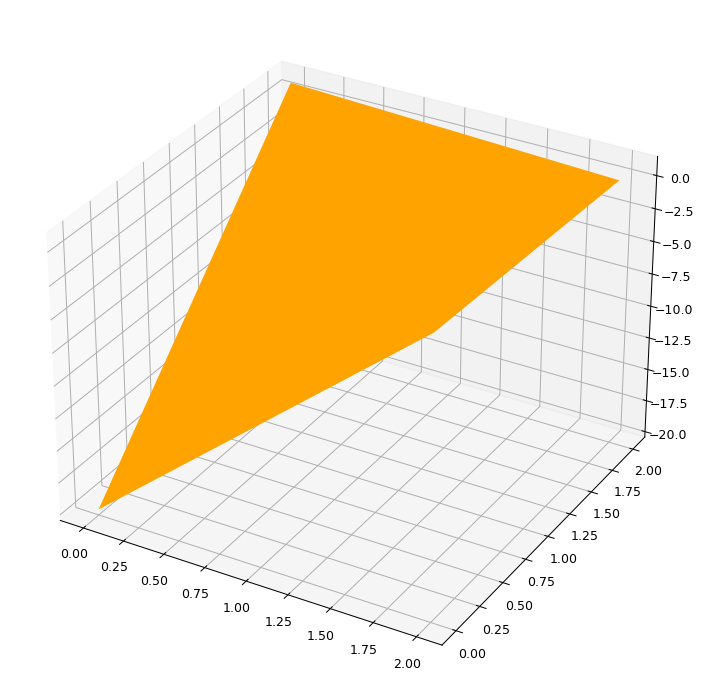

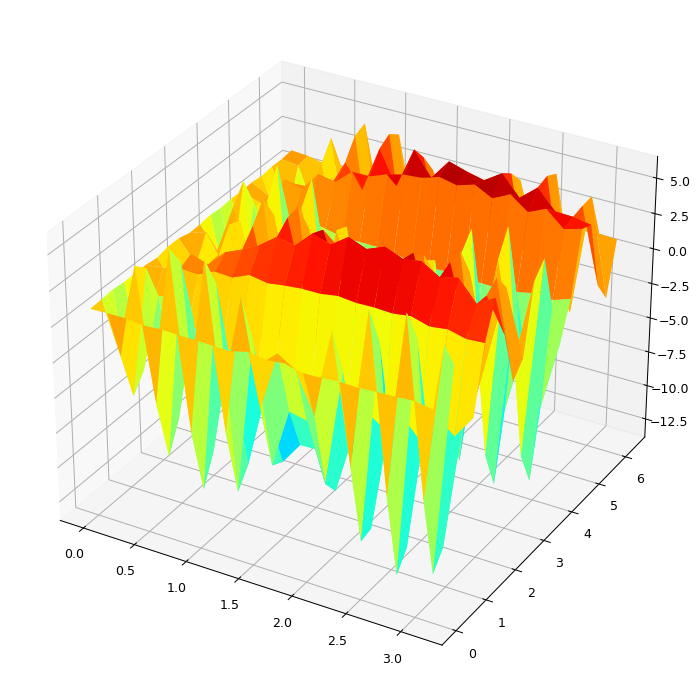

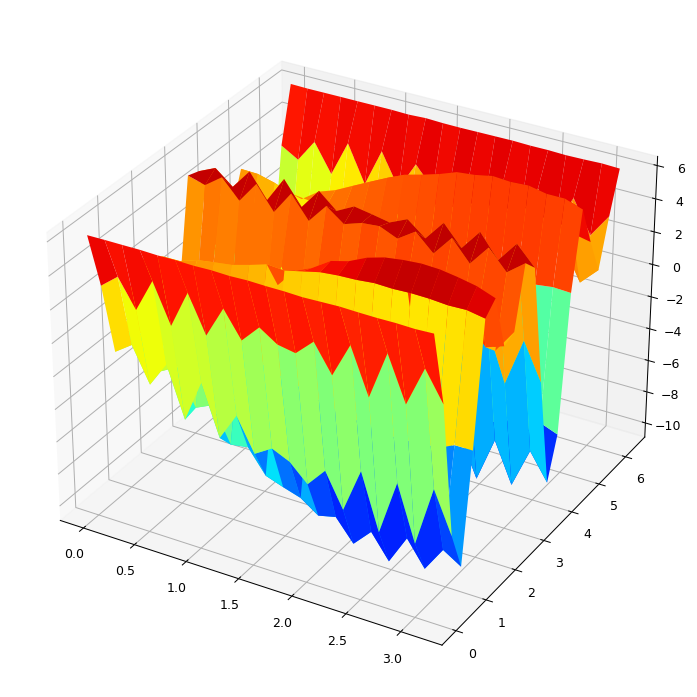

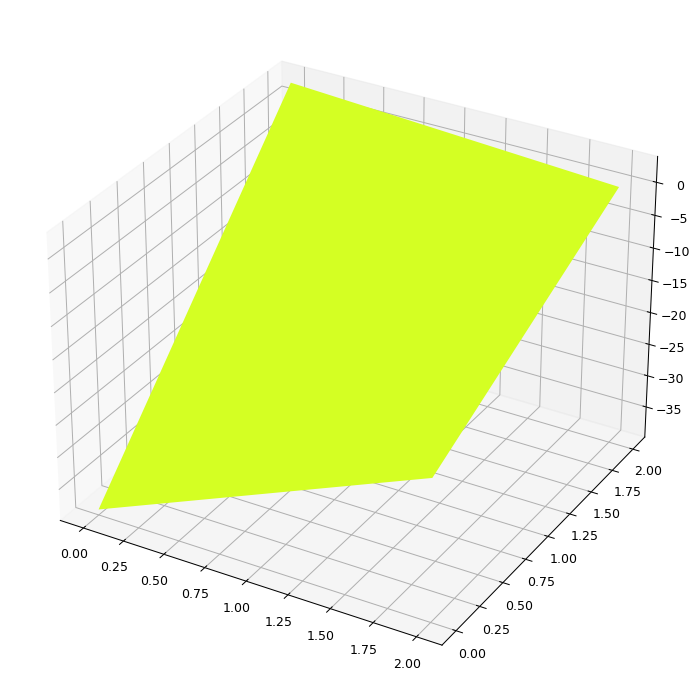

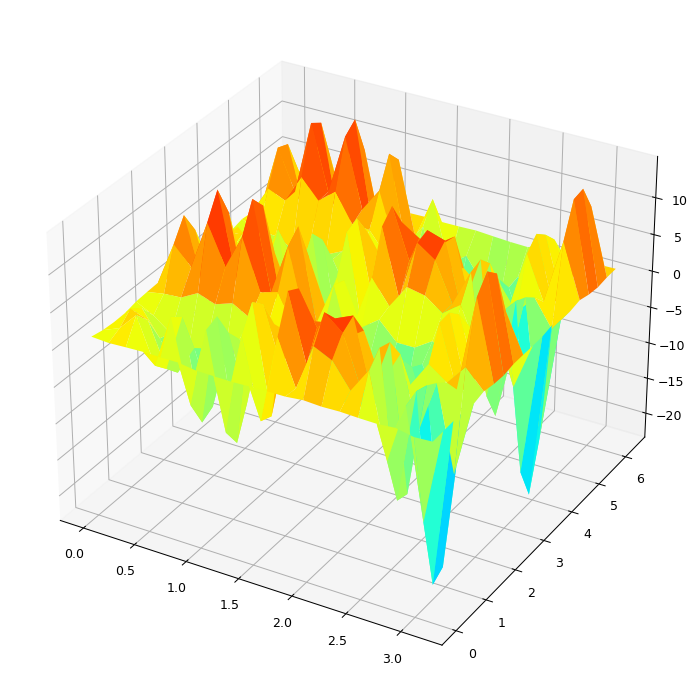

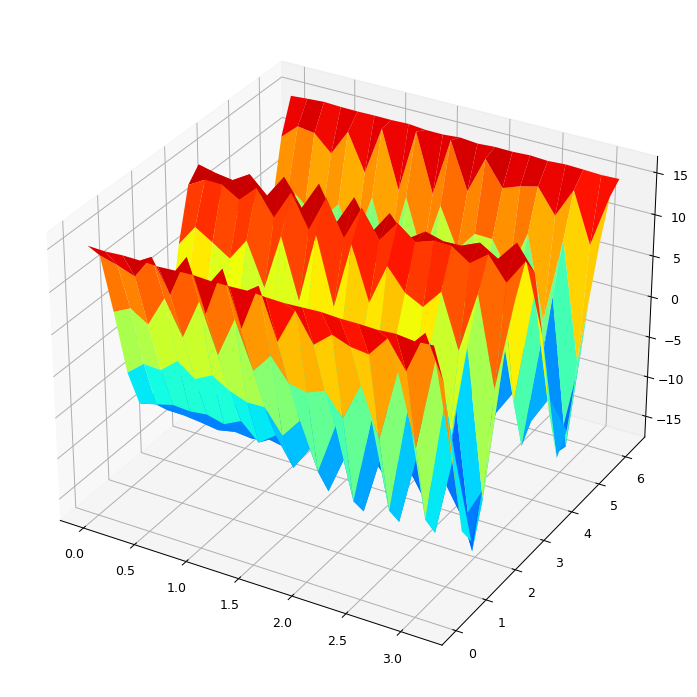

In [21]:
import time

def game_loop():
    global n, board, human_pos, machine_pos
    human_pos = []
    machine_pos = []
    n = get_int_from_user(message="Board length/width (N x N sized board): ", lower_bound=1)
    while not is_power_of_2(n):
        print("N must be a power of 2! (eg. N = 2, 4, 8, etc.)")
        n = get_int_from_user(message="Board length/width (N x N sized board): ", lower_bound=1)
    num_qubits = get_min_num_qubits(n)
    num_connect = get_int_from_user(message="Number of blocks to connect to win (X in \"connect-X\"): ", lower_bound=1)
    board = [[0]*n for _ in range(n)]
    turn = 0
    
    while not end_state(board, num_connect, turn):
        print("Turn: {}".format("Human Player" if turn % 2 == 0 else "Machine Player"))
        print(np.array(board))
        if turn % 2 == 0: # Human turn
            row = get_int_from_user(message="Row Number [1 to {}, inclusive]: ".format(n))
            col = get_int_from_user(message="Column Number [1 to {}, inclusive]: ".format(n))
            human_pos.append([row, col])
        else: # Machine turn
            # get row, col from quantum algorithm
            cost = cost_func(machine_pos, human_pos, int(n))
            print(cost)
            ham = get_hamiltonian_from_cost_func(cost, num_qubits)
            row, col, counts = choose_best_pos(ham, cost, n)
            print(row,col)
            machine_pos.append([row, col])
            
        place_piece(turn, board, row, col)
        turn += 1 
        
game_loop()

In [ ]:
memes = [[0,0],[1,2]]
final_cost = cost_func(memes,[[1,0],[0,1],[1,1]],4)
print(final_cost)
print(change_of_base(memes[0],4))


In [ ]:
for i in range(0,2):
    print(i)

In [ ]:
machine_pos = [(2,3),(3,3),(1,5),(5,7)]
human_pos = [(1,1),(2,4),(7,6),(5,5)]
n=8
cost = cost_func(machine_pos, human_pos, int(n))
ham = get_hamiltonian_from_cost_func(cost, 6)
row, col, counts = choose_best_pos(ham, cost, 6)